# NATRE

Reproducing the Ferrari & Polzin (2005) estimate using NATRE data, and comparing differences with our version

In [1]:
%load_ext watermark

import glob

import cf_xarray as cfxr
import dcpy
import distributed
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from IPython.display import Image

xr.set_options(keep_attrs=True)
mpl.rcParams["figure.dpi"] = 140

%watermark -iv

xarray     : 0.16.3.dev119+g8a3912c72.d20210202
dcpy       : 0.1
matplotlib : 3.3.3
cf_xarray  : 0.4.1.dev16+g5b2357c.d20210201
distributed: 2021.1.1
numpy      : 1.19.5



In [2]:
if "client" in locals():
    client.cluster.close()
    client.close()
client = distributed.Client(n_workers=4)
client

<Client: 'tcp://127.0.0.1:35653' processes=4 threads=8, memory=33.39 GB>

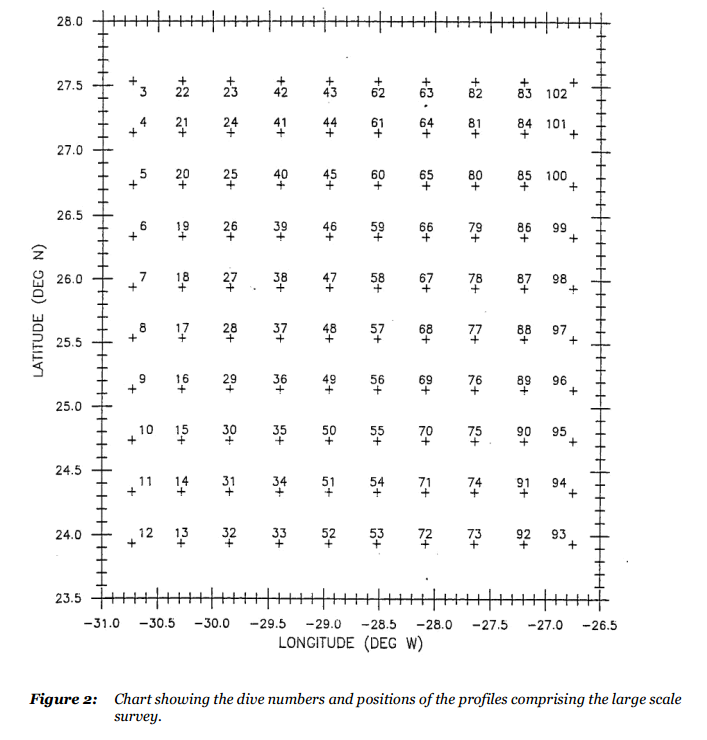

In [4]:
Image("../images/natre-large-scale.png")

## Read dataset

created using ``eddydiff.natre.combine_natre_files()``



In [25]:
def gamma_n(ds):
    """ Xarray wrapper for Eric Firing's netural density wrapper"""

    import pygamma

    def gamma_n_wrapper(*args):
        g = pygamma.gamma_n(*args)[0]
        g[g < 0.1] = np.nan  # bad values are 0?
        return g

    if ds.salt.ndim > 2:
        # pygamma only accepts 2D at the most.
        # and depth must be the second dimension
        stacked = True
        ds = ds.cf.stack(latlon=["latitude", "longitude"]).transpose("latlon", ...)

    gamma = xr.apply_ufunc(
        gamma_n_wrapper,
        ds.salt,
        ds.temp,
        ds.pres,
        ds.longitude,
        ds.latitude,
        input_core_dims=[["depth"], ["depth"], ["depth"], [], []],
        output_core_dims=[["depth"]],
        dask="parallelized",
        output_dtypes=[ds.salt.dtype],
    )
    gamma.attrs["standard_name"] = "neutral_density"
    gamma.attrs["units"] = "kg/m3"
    gamma.attrs["long_name"] = "$γ_n$"

    if stacked:
        gamma = gamma.unstack()
    return gamma

In [26]:
natre = xr.open_dataset(
    "../datasets/natre_large_scale.nc", chunks={"latitude": 5, "longitude": 5}
)
natre = natre.where(natre.chi.notnull() & natre.eps.notnull())

In [120]:
natre = natre.set_coords(["time", "pres"])
natre = natre.cf.guess_coord_axis()

natre.chi.attrs["long_name"] = "$χ$"
natre.eps.attrs["long_name"] = "$ε$"
natre["depth"].attrs.update(units="m", positive="down")

natre["theta"] = dcpy.eos.ptmp(natre.salt, natre.temp, natre.pres, pr=1000)
natre["theta"].attrs.update(long_name="$θ$")

natre["pden"] = dcpy.eos.pden(natre.salt, natre.temp, natre.pres, pr=1000)
natre["pden"].attrs.update(long_name="$ρ$")

natre["gamma_n"] = gamma_n(natre)

natre["Tz"] = -1 * natre.theta.interpolate_na("depth").differentiate("depth")
natre["Tz"].attrs["long_name"] = "$θ_z$"

natre["N2"] = 9.81 / 1025 * natre.gamma_n.interpolate_na("depth").differentiate("depth")
natre["N2"].attrs["long_name"] = "$N²$"

Tz_mask = np.abs(natre.Tz) > 1e-3
N2_mask = np.abs(natre.N2) > 1e-6

natre["chi_masked"] = natre.chi.where(Tz_mask)

natre["Krho"] = (0.2 * natre.eps / natre.N2).where(N2_mask)
natre["Krho"].attrs["long_name"] = "$K_ρ$"
natre["Krho"].attrs["units"] = "m²/s"

natre["Kt"] = (natre.chi / 2 / natre.Tz ** 2).where(Tz_mask)
natre["Kt"].attrs["long_name"] = "$K_T$"
natre["Kt"].attrs["units"] = "m²/s"

natre["KtTz"] = natre.Kt * natre.Tz
natre["KtTz"].attrs["long_name"] = "$K_t θ_z$"

natre["KrhoTz"] = natre.Krho * natre.Tz.where(Tz_mask)
natre["KrhoTz"].attrs["long_name"] = "$K_ρ θ_z$"

# natre["KrhoN2"] = natre.Krho * np.sqrt(natre.N2)
# natre["KrhoN2"].attrs["long_name"] = "$K_ρ N$"

natre["eps_chi"] = (
    1 / 2 * natre.chi * natre.N2.where(N2_mask) / 0.2 / (natre.Tz.where(Tz_mask) ** 2)
)
natre["eps_chi"].attrs["long_name"] = "$ε_χ$"
natre["eps_chi"].attrs["units"] = "W/kg"

natre = natre.where(natre.chi > 1e-14)

natre.load()

<xarray.Dataset>
Dimensions:             (depth: 7961, latitude: 10, longitude: 10)
Coordinates:
    pres                (latitude, longitude, depth) float64 nan nan ... nan nan
    time                (latitude, longitude, depth) datetime64[ns] NaT ... NaT
  * depth               (depth) float64 10.2 10.6 11.0 ... 3.194e+03 3.194e+03
  * latitude            (latitude) float64 27.5 27.1 26.7 ... 24.7 24.3 23.9
  * longitude           (longitude) float64 -30.7 -30.3 -29.8 ... -27.2 -26.8
    reference_pressure  int64 1000
Data variables: (12/15)
    chi                 (latitude, longitude, depth) float64 nan nan ... nan nan
    eps                 (latitude, longitude, depth) float64 nan nan ... nan nan
    salt                (latitude, longitude, depth) float64 nan nan ... nan nan
    temp                (latitude, longitude, depth) float64 nan nan ... nan nan
    theta               (latitude, longitude, depth) float64 nan nan ... nan nan
    pden                (latitude, longitude, depth) float64 nan nan ... nan nan
    ...                  ...
    Krho                (latitude, longitude, depth) float64 nan nan ... nan nan
    Kt                  (latitude, longitude, depth) float64 nan nan ... nan nan
    KtTz                (latitude, longitude, depth) float64 nan nan ... nan nan
    KrhoTz              (latitude, longitude, depth) float64 nan nan ... nan nan
    eps_chi             (latitude, longitude, depth) float64 nan nan ... nan nan
    chi_masked          (latitude, longitude, depth) float64 nan nan ... nan nan
Attributes: (12/13)
    Conventions:           CF-1.6
    netcdf_version:        4
    project:               North Atlantic Tracer Release Experiment (NATRE)
    expocode:              32OC250_4
    cast_number:           3.0
    title:                 Microstructure profiler data from the ship Oceanus...
    ...                    ...
    latitude:              27.533166666666666
    longitude:             -30.723333333333333
    chief_scientist:       Raymond W. Schmitt
    data_originator:       Polzin
    institution:           WHOI
    data_assembly_center:  CCHDO

/home/deepak/work/python/xarray/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/home/deepak/work/python/xarray/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/home/deepak/work/python/xarray/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)
/home/deepak/work/python/xarray/xarray/core/computation.py:724: RuntimeWarning: invalid value encountered in log10
  result_data = func(*input_data)


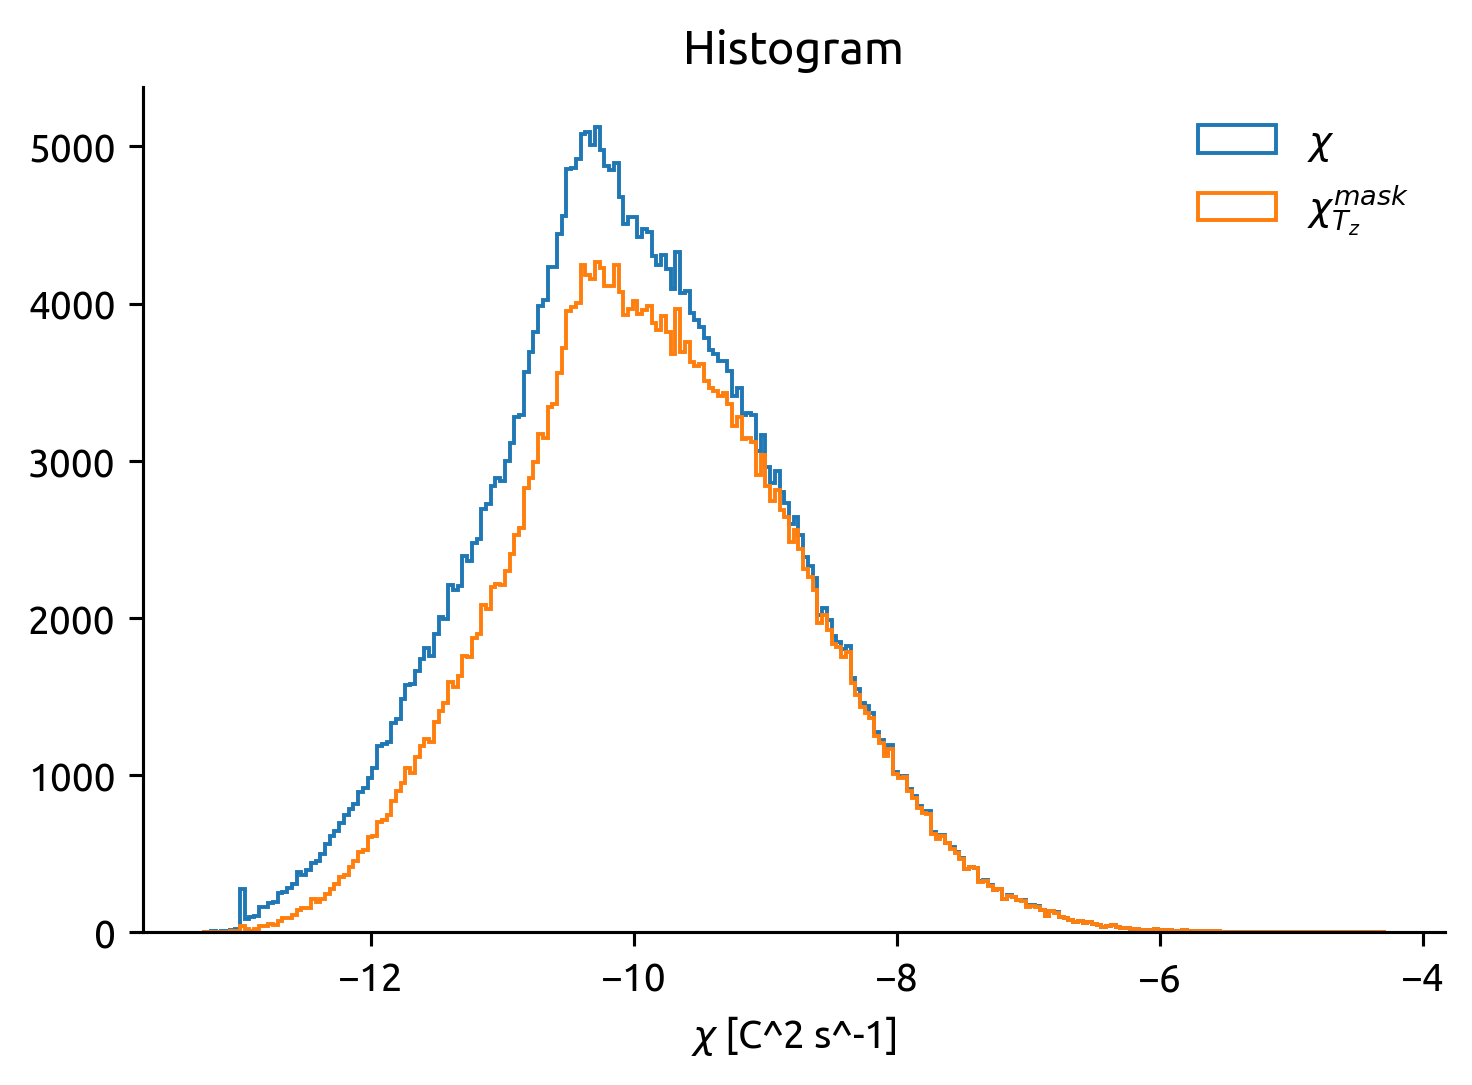

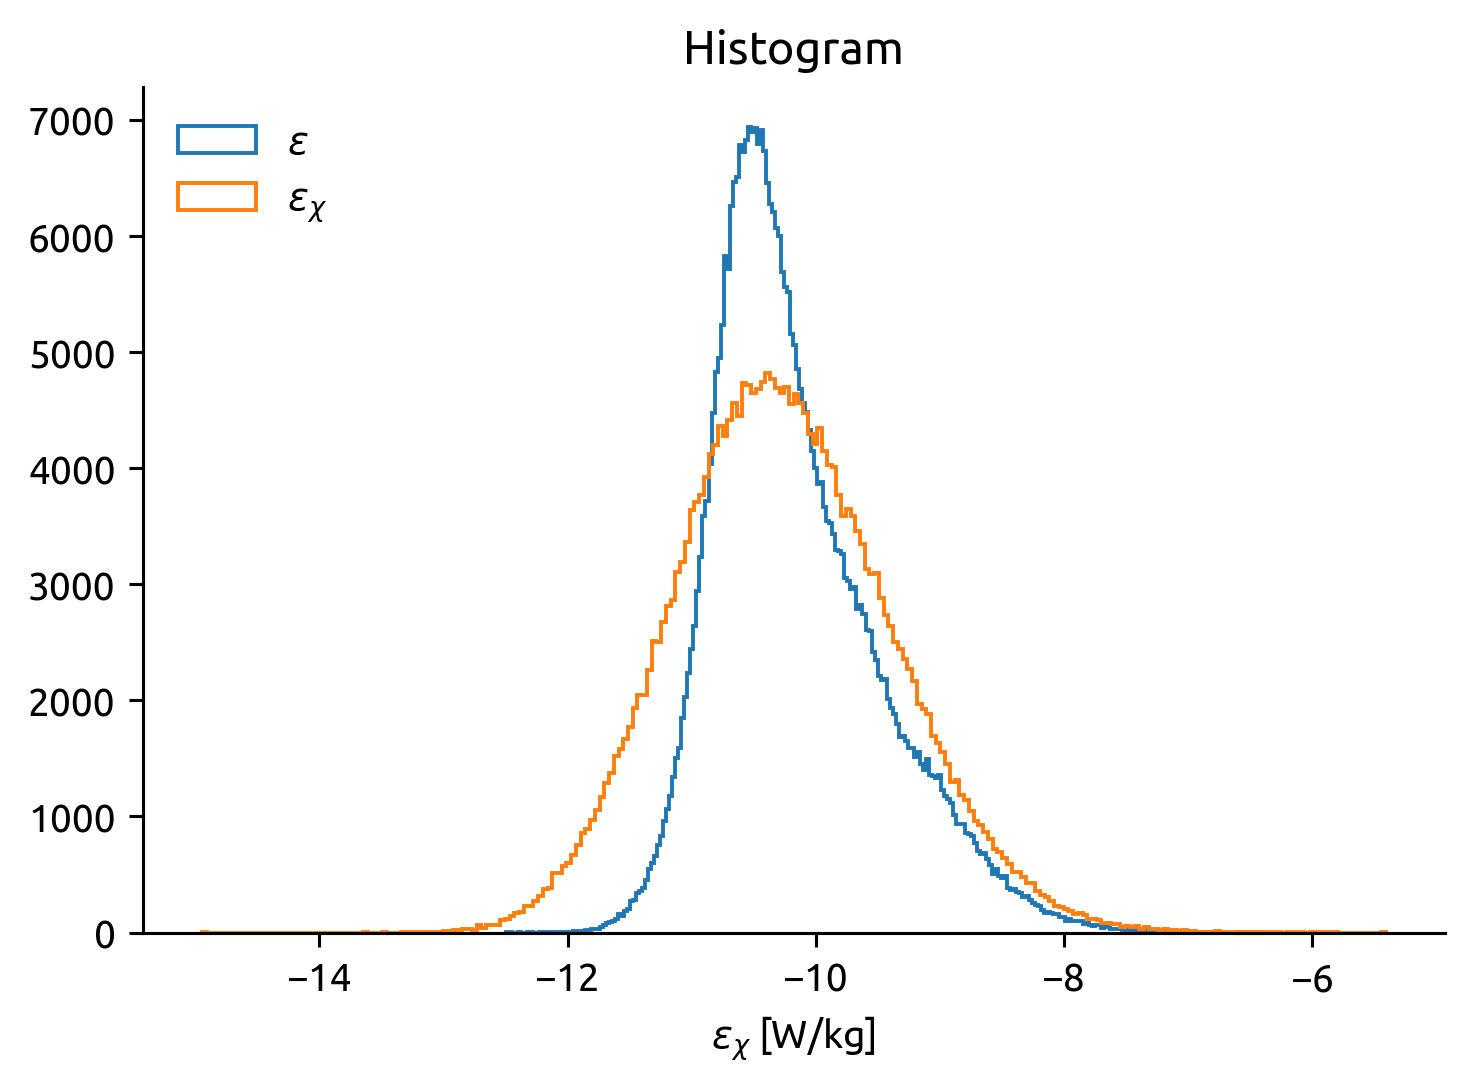

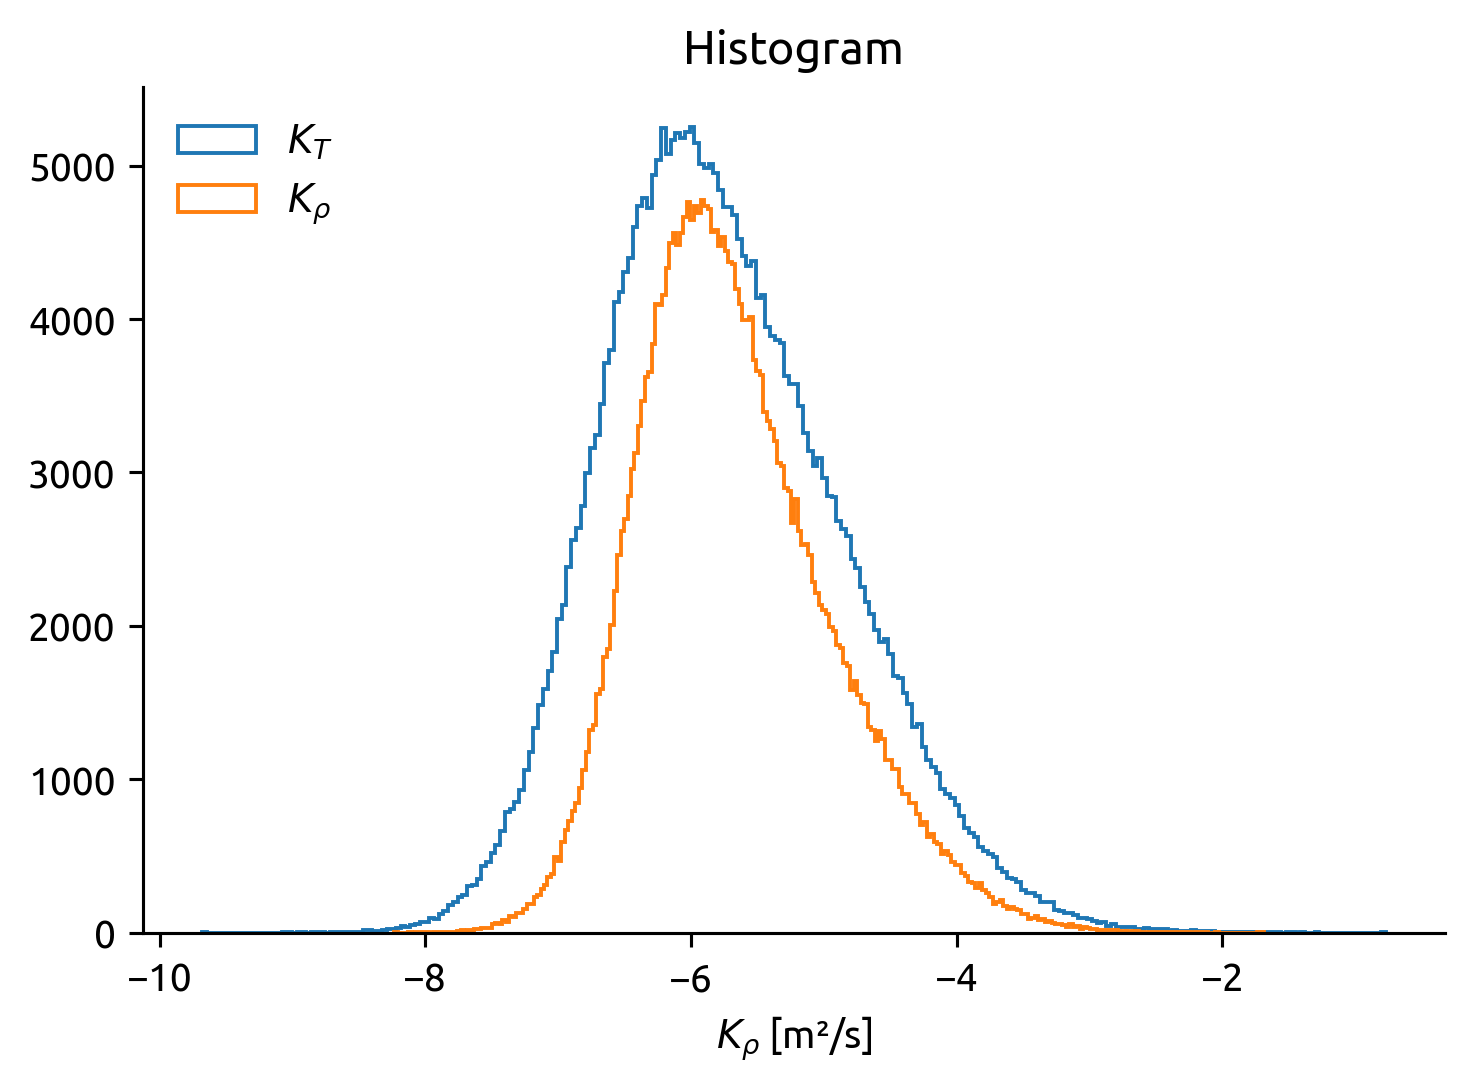

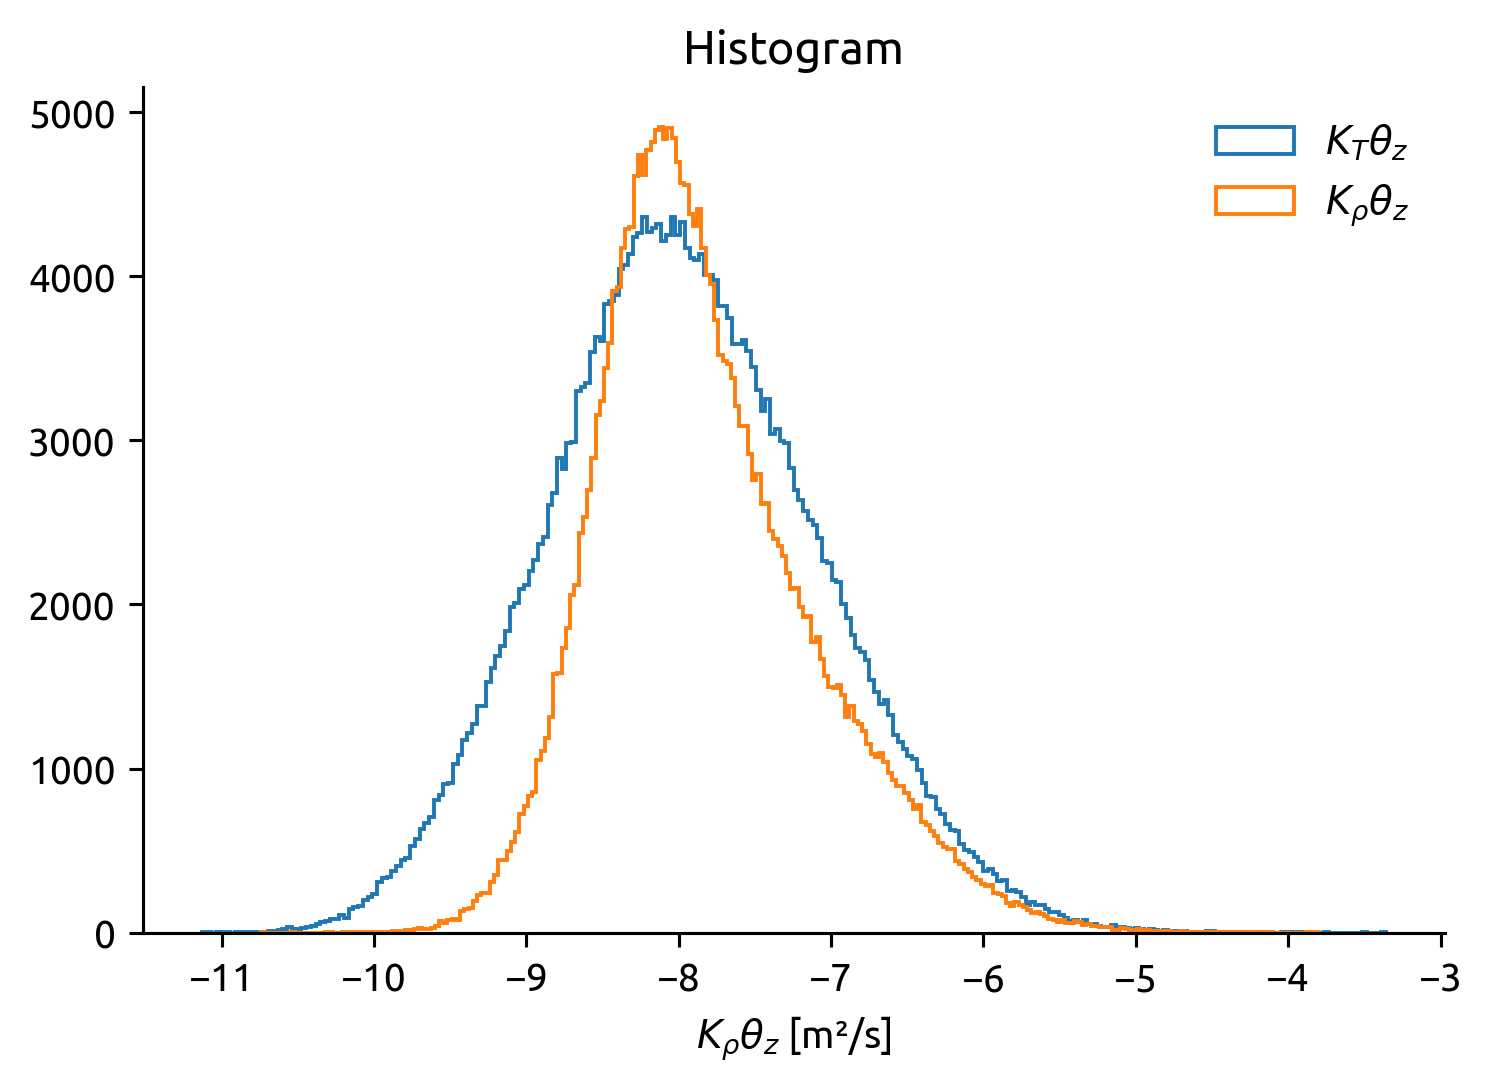

In [122]:
kwargs = dict(bins=250, histtype="step", density=False)
plt.figure()
np.log10(natre.chi).plot.hist(**kwargs)
np.log10(natre.chi_masked).plot.hist(**kwargs)
plt.legend(["$χ$", "$χ_{T_z}^{mask}$"])

plt.figure()
np.log10(natre.eps).plot.hist(**kwargs)
np.log10(natre.eps_chi).plot.hist(**kwargs)
plt.legend(["$ε$", "$ε_χ$"])

plt.figure()
np.log10(natre.Kt).plot.hist(**kwargs)
np.log10(natre.Krho).plot.hist(**kwargs)
plt.legend(["$K_T$", "$K_ρ$"])

plt.figure()
np.log10(natre.KtTz).plot.hist(**kwargs)
np.log10(natre.KrhoTz).plot.hist(**kwargs)
plt.legend(["$K_T θ_z$", "$K_ρ θ_z$"])

In [84]:
(
    natre["chi"]
    .where(natre.chi > 1e-14)
    .rolling(depth=250, center=True, min_periods=1)
    .mean()
    .compute()
).plot.line(
    y="depth",
    col="longitude",
    row="latitude",
    # norm=mpl.colors.LogNorm(1e-12, 1e-5),
    # cmap=mpl.cm.Spectral_r,
    yincrease=False,
    xlim=[1e-12, 1e-7],
    ylim=(2000, 0),
    xscale="log",
    # robust=True,
    # col_wrap=4,
)

## Procedure

The large-scale average operator ⟨⟩ represents 
1. a horizontal average over the survey lateral scale,
2. a vertical average over O(100) m, and
3. a time average over the 18-day survey.


The mean fields are derived by averaging all variables along neutral-density surfaces $γ_n$

Mean vertical gradients $∂_z θ_m$, $∂_z S_m$, and $∂_z b_m$, are calculated from O(100)-m linear fits to $θ_m(z_n)$,
$S_m(z_n)$, and $b_m(z_n)$, where $z_n$ is the mean depth of each surface $γ_n$. 

large-scale temperature gradient $|∇_n θ_m|$ is estimated by fitting
a plane to the 100 stations in the 400 km × 400 km
large-scale survey grid and rms is computed as the standard deviation of the departures from the plane fit. 

In theory, these bins are approx. 100m apart in neutral density

### Choose bins

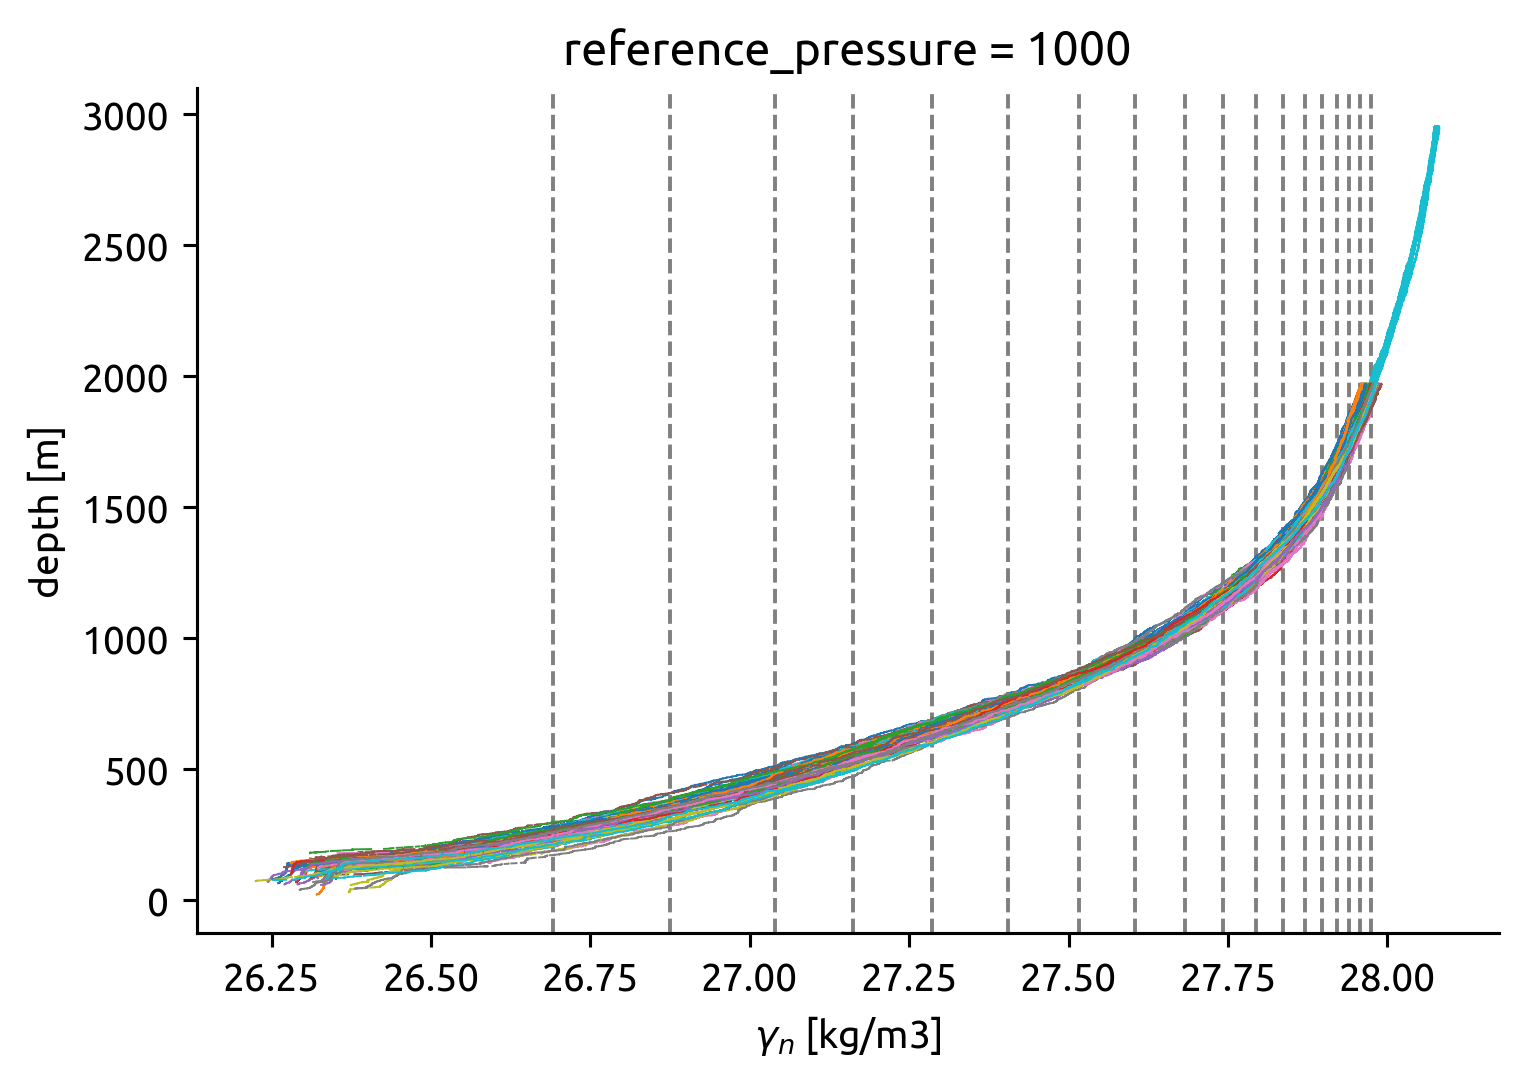

In [313]:
bins = natre.gamma_n.mean(["latitude", "longitude"]).interp(depth=np.arange(150, 2001, 100)).dropna("depth").data
natre.gamma_n.stack({"latlon": ["latitude", "longitude"]}).drop("latlon").cf.plot(hue="latlon", y="depth", lw=0.5, add_legend=False);
dcpy.plots.linex(bins)

### old potential density selection

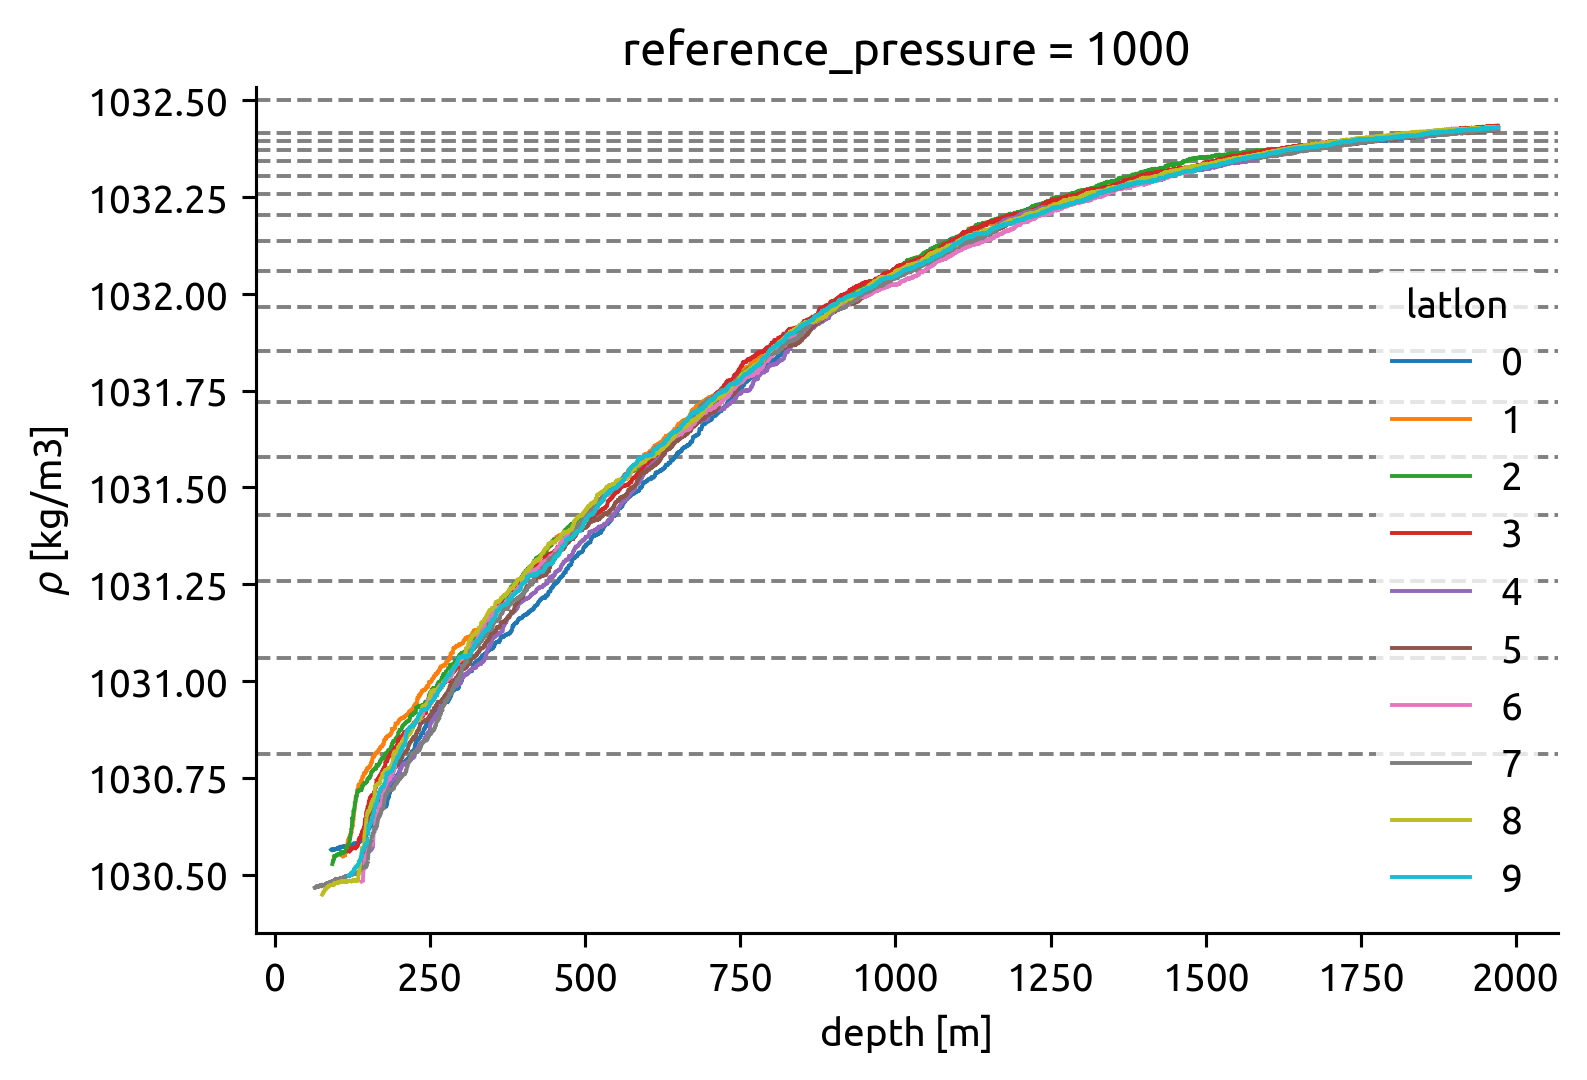

In [307]:
# bins = np.arange(1026.5, 1028.7, 0.2)
bins = [
    1030.81154836,
    1031.05957777,
    1031.25784152,
    1031.42899149,
    1031.57905569,
    1031.72019646,
    1031.85230913,
    1031.9654204,
    1032.05809164,
    1032.13639824,
    1032.20300346,
    1032.25857768,
    1032.30501071,
    1032.34271354,
    1032.3724109,
    1032.39573096,
    1032.41578357,
    1032.5
]
natre.pden.stack(latlon=["latitude", "longitude"]).drop("latlon").isel(latlon=slice(None, None, 10)).cf.plot.line(hue="latlon")
dcpy.plots.liney(bins)

Test that χ looks OK

/home/deepak/miniconda3/envs/dcpy/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


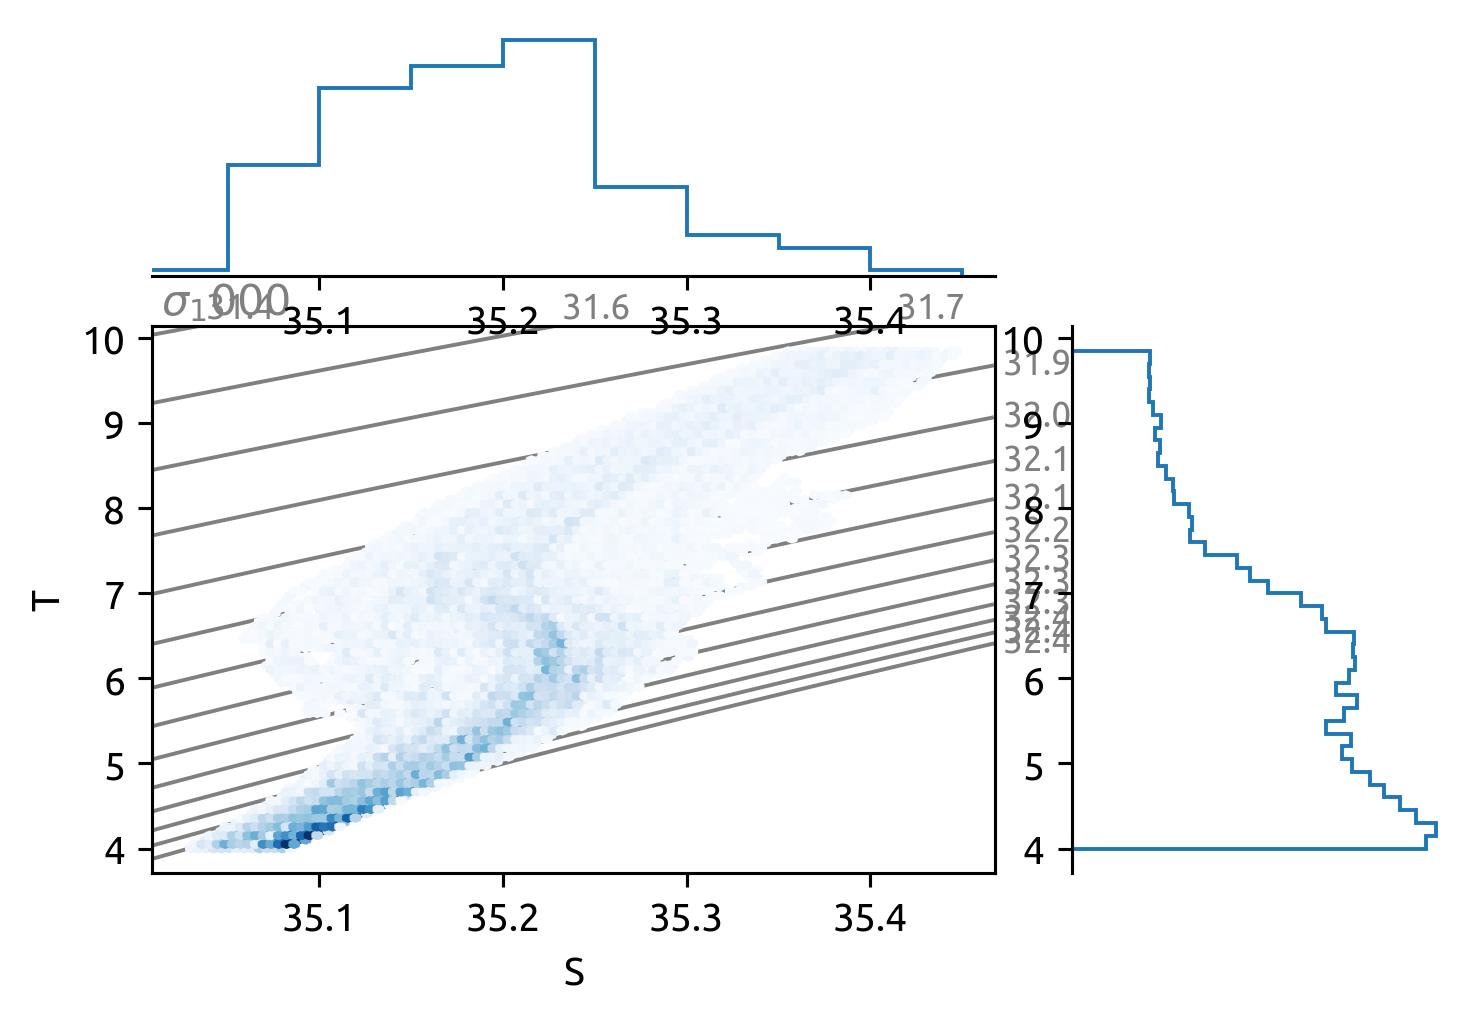

In [9]:
hdl, axes = dcpy.oceans.TSplot(
    natre.salt,
    natre.theta,
    Pref=1000,
    rho_levels=bins,
    Sbins=np.arange(35, 35.5, 0.05),
    Tbins=np.arange(4, 10, 0.15),
)

## Make estimate

In [115]:
bins = natre.gamma_n.mean(["latitude", "longitude"]).interp(depth=np.arange(150, 2001, 100)).dropna("depth").data

grouped = natre.reset_coords("pres").cf.groupby_bins("neutral_density", bins=bins)
chidens = grouped.mean()

groupvar = "gamma_n_bins"  # "pden_bins"
chidens[groupvar].attrs = natre.cf["neutral_density"].attrs
# chidens[groupvar].attrs["positive"] = "down"
chidens[groupvar].attrs["axis"] = "Z"
chidens = chidens.set_coords("pres")
chidens["pres"].attrs["positive"] = "down"
chidens

<xarray.Dataset>
Dimensions:             (gamma_n_bins: 17)
Coordinates:
  * gamma_n_bins        (gamma_n_bins) object (26.692, 26.876] ... (27.958, 2...
    pres                (gamma_n_bins) float64 302.4 405.7 ... 1.906e+03
    reference_pressure  int64 1000
Data variables: (12/15)
    chi                 (gamma_n_bins) float64 6.095e-09 3.71e-09 ... 2.339e-10
    eps                 (gamma_n_bins) float64 6.136e-10 5.582e-10 ... 1.094e-10
    salt                (gamma_n_bins) float64 36.16 35.87 35.68 ... 35.1 35.09
    temp                (gamma_n_bins) float64 15.65 13.86 12.45 ... 4.485 4.264
    theta               (gamma_n_bins) float64 15.76 13.95 12.52 ... 4.408 4.18
    pden                (gamma_n_bins) float64 1.031e+03 1.031e+03 ... 1.032e+03
    ...                  ...
    Krho                (gamma_n_bins) float64 1.086e-05 1.21e-05 ... 4.369e-06
    Kt                  (gamma_n_bins) float64 2.342e-05 2.413e-05 ... 1.396e-05
    KtTz                (gamma_n_bins) float64 1.401e-07 1.106e-07 ... 3.07e-08
    KrhoTz              (gamma_n_bins) float64 1.257e-07 1.078e-07 ... 1.999e-08
    eps_chi             (gamma_n_bins) float64 1.11e-09 1.086e-09 ... 2.134e-10
    chi_masked          (gamma_n_bins) float64 6.16e-09 3.769e-09 ... 2.846e-10
Attributes: (12/13)
    Conventions:           CF-1.6
    netcdf_version:        4
    project:               North Atlantic Tracer Release Experiment (NATRE)
    expocode:              32OC250_4
    cast_number:           3.0
    title:                 Microstructure profiler data from the ship Oceanus...
    ...                    ...
    latitude:              27.533166666666666
    longitude:             -30.723333333333333
    chief_scientist:       Raymond W. Schmitt
    data_originator:       Polzin
    institution:           WHOI
    data_assembly_center:  CCHDO

### Vertical gradients

> Mean vertical gradients $∂_z θ_m$, $∂_z S_m$, and $∂_z b_m$, are calculated from O(100)-m linear fits to $θ_m(z_n)$, $S_m(z_n)$, and $b_m(z_n)$, where $z_n$ is the mean depth of each surface $γ_n$. 

I don't understand this. The bins are O(100m) apart, so how do you "fit" straight lines over O(100)-m to a profile that has points every O(100)m.



In [86]:
def fit1D(group, var, dim="depth", debug=False):
    """
    Expects a bunch of profiles at differ lat, lons.
    Calculates mean profile and then takes linear fit to estimate gradient.
    """
    ds = group.unstack()
    stacked = ds[var].stack(latlon=("latitude", "longitude")).drop("latlon")

    # move to a relative-depth reference frame for proper averaging
    stacked["z0"] = stacked[dim] - stacked[dim].where(stacked.notnull()).mean(dim)
    stacked -= stacked.mean(dim)

    if debug:
        f, ax = plt.subplots(2, 2, constrained_layout=True)
        kwargs = dict(add_legend=False, lw=0.5)
        stacked.plot.line(y=dim, ax=ax[0, 0], **kwargs)
        stacked.plot.line(y="z0", **kwargs, ax=ax[0, 1])

    binned = stacked.groupby_bins("z0", bins=np.arange(-10, 200, 2))
    count = binned.count()
    min_count = 300  # count.median() / 1.25
    mean_profile = binned.mean().where(count > min_count)
    mean_profile["z0_bins"] = mean_profile.indexes["z0_bins"].mid

    poly = (mean_profile).polyfit("z0_bins", deg=1)
    slope = poly.polyfit_coefficients.sel(degree=1, drop=True)

    if debug:
        mean_profile.plot(ax=ax[1, 0])
        xr.polyval(
            mean_profile.z0_bins.sel(z0_bins=slice(50)), poly.polyfit_coefficients
        ).plot(ax=ax[1, 0])
        ax[1, 0].text(x=0.1, y=0.8, s=str(slope.item()), transform=ax[1, 0].transAxes)

    return slope


for idx, (label, group) in enumerate(grouped):
    if idx == 10:
        break

fit1D(group, var="pden", debug=True)

for idx, (label, group) in enumerate(grouped):
    if idx == 15:
        break

fit1D(group, var="theta", debug=True)

TypeError: '_CFWrappedClass' object is not iterable

### Horizontal gradients

large-scale temperature gradient $|∇_n θ_m|$ is estimated by fitting
a plane to the 100 stations in the 400 km × 400 km
large-scale survey grid and rms is computed as the standard deviation of the departures from the plane fit. 

In [87]:
def fit2D(group, debug=False):
    from scipy.interpolate import RectBivariateSpline

    pden = (
        group.unstack()
        .mean("depth")
        .theta.sortby("latitude")
        # .isel(longitude=slice(1, -1), latitude=slice(1, -1))
    )
    pden = pden.cf.guess_coord_axis()
    x, y = dcpy.util.latlon_to_xy(pden.cf["latitude"], pden.cf["longitude"])
    x -= x.min()
    y -= y.min()
    pden.coords["x"] = x.mean("latitude")
    pden.coords["y"] = y.mean("longitude")
    if debug:
        plt.figure()
        pden.cf.plot()

    spl = RectBivariateSpline(
        x=pden.cf["X"].data, y=pden.cf["Y"].data, z=pden.data, kx=1, ky=1, s=1
    )
    if debug:
        print(spl.get_residual())

    fit = pden.copy(data=spl(pden.cf["X"], pden.cf["Y"]))
    test = xr.concat([pden, fit], dim=xr.Variable("kind", ["actual", "fit"]))

    if debug:
        plt.figure()
        fit.cf.plot()

        plt.figure()
        test.isel(longitude=5).plot(hue="kind")

        plt.figure()
        test.isel(latitude=6).plot(hue="kind")

    slope = xr.Dataset()
    slope["x"] = (
        fit.polyfit("longitude", deg=1, use_coordinate="x")
        .sel(degree=1, drop=True)
        .median()
        .to_array()
    )
    slope["y"] = (
        fit.polyfit("latitude", deg=1, use_coordinate="y")
        .sel(degree=1, drop=True)
        .median()
        .to_array()
    )
    slope = slope.squeeze().drop_vars("variable") #.expand_dims(pden_bins=[label])
    return slope

### More Calculations

In [123]:
chidens["dTdz_m"] = -1 * grouped.apply(fit1D, var="theta", dim="depth")
chidens.dTdz_m.attrs.update(dict(name = "$∂_z θ_m$", units = "°C/m"))

chidens["N2_m"] = 9.81 / 1030 * grouped.apply(fit1D, var="pden", dim="depth")
chidens.N2_m.attrs.update(dict(name = "$∂_zb_m$", units = "s$^{-2}$"))

chidens["Krho_m"] = 0.2 * chidens.eps / chidens.N2_m
chidens.Krho.attrs.update(dict(long_name="$K_ρ^m$", units="m²/s"))

chidens["Kt_m"] = chidens.chi / 2 / chidens.dTdz_m ** 2
chidens.Krho.attrs.update(dict(long_name="$K_T^m$", units="m²/s"))

In [ ]:
iso_slope = grouped.apply(fit2D)
chidens["dTiso"] = np.hypot(iso_slope.x, iso_slope.y)
chidens["dTiso"]

### Checking estimate

Ke is totally wrong!, I need to fix my plane fitting

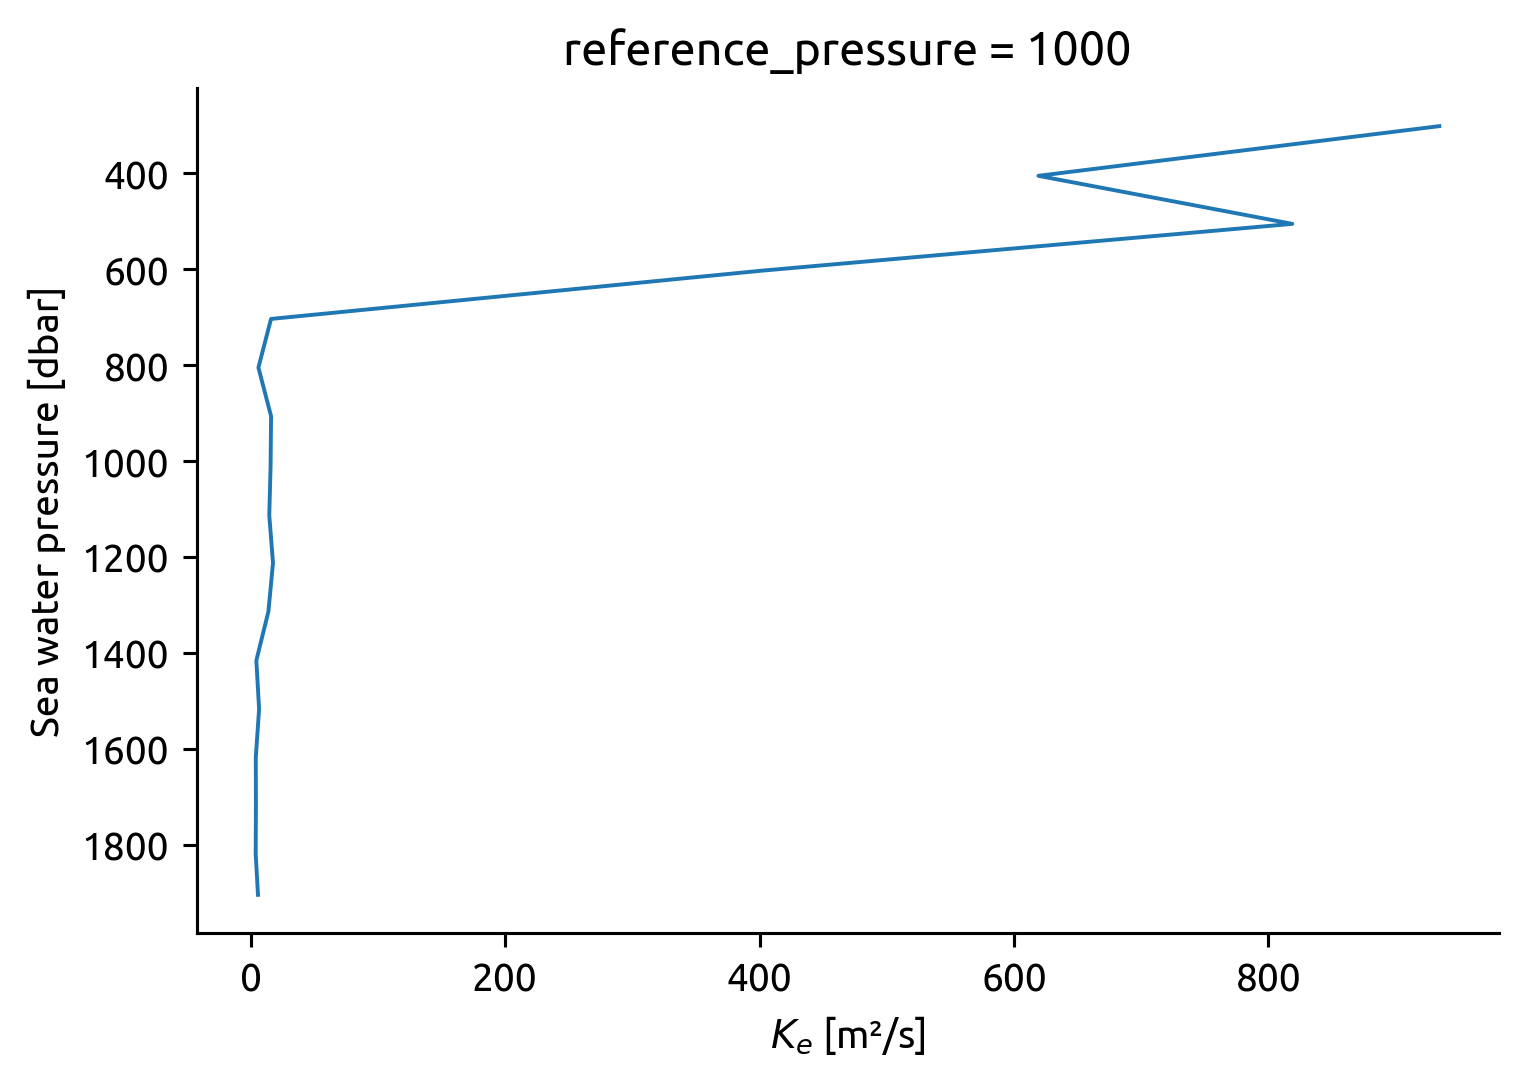

In [486]:
chidens["Ke"] = (chidens.chi/2 - chidens.Krho_m * chidens.dTdz_m**2) / chidens.dTiso ** 2
chidens["Ke"].attrs["long_name"] = '$K_e$'
chidens["Ke"].attrs["units"] = "m²/s"
chidens["Ke"].cf.plot()

Replicate some Ferrari & Polzin (2005) figures. $K_ρ, ε$ look OK. $K_e$ is wrong, something is wrong with my slope estimate / plane fitting

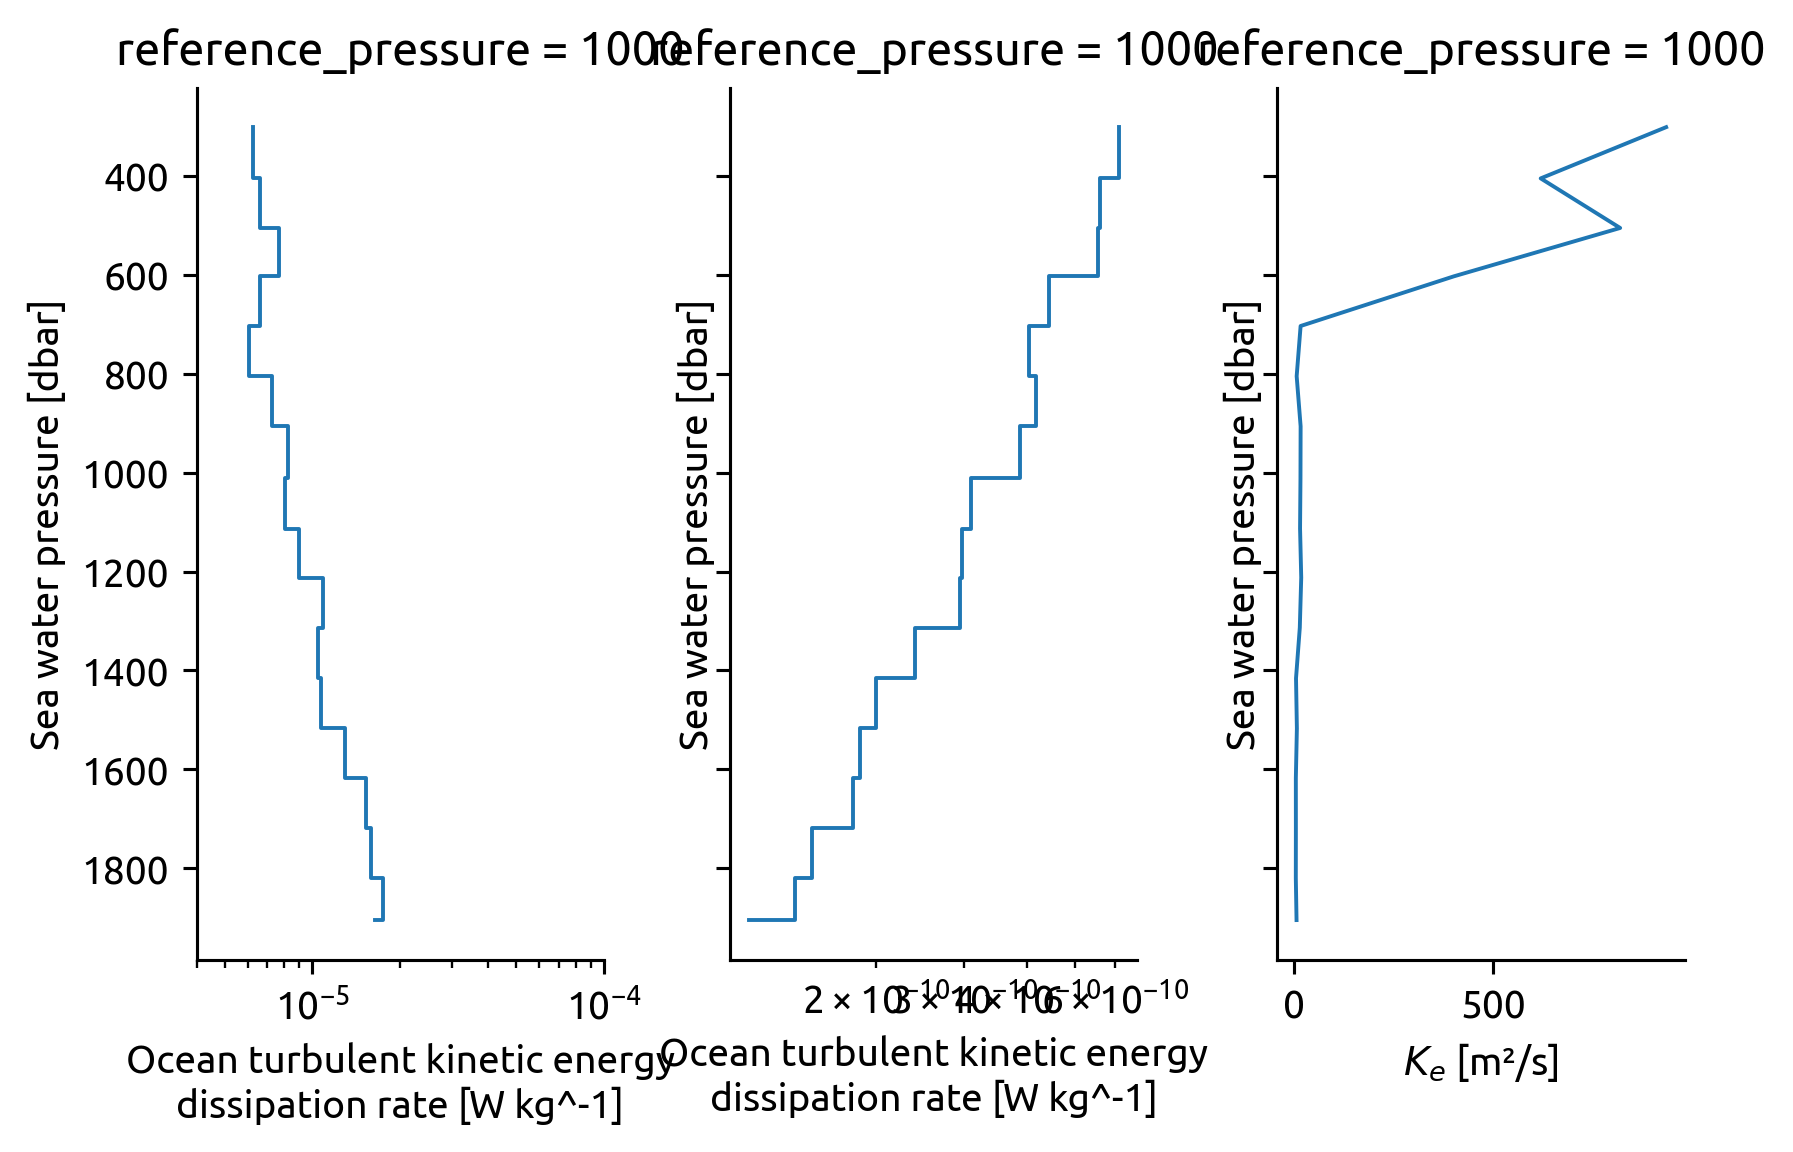

In [487]:
f, ax = plt.subplots(1, 3, sharey=True, constrained_layout=True)
chidens.Krho_m.cf.plot.step(xscale="log", xlim=(4e-6, 1e-4), ax=ax[0])
chidens.eps.cf.plot.step(ax=ax[1], xscale="log")
chidens["Ke"].cf.plot(ax=ax[2])

## Reproducing production vs dissipation

Ferrari & Polzin use $⟨u_t θ_t⟩.∇θ_m = -Γ ⟨ε⟩/N_m^2  ∂_zθ_m^2$, we are instead doing $-⟨K_T θ_z⟩ ∂_zθ_m$. Our estimate mostly agrees with theirs. 


1. Filling in NaNs in the temperature profiles was important. This means more estimates are used in the averages
2. Masked where both $χ$ and $ε$ are both available.
3. Masked so that $|θ_z|$ > 1e-3 (really important, otherwise our estimate is too high)

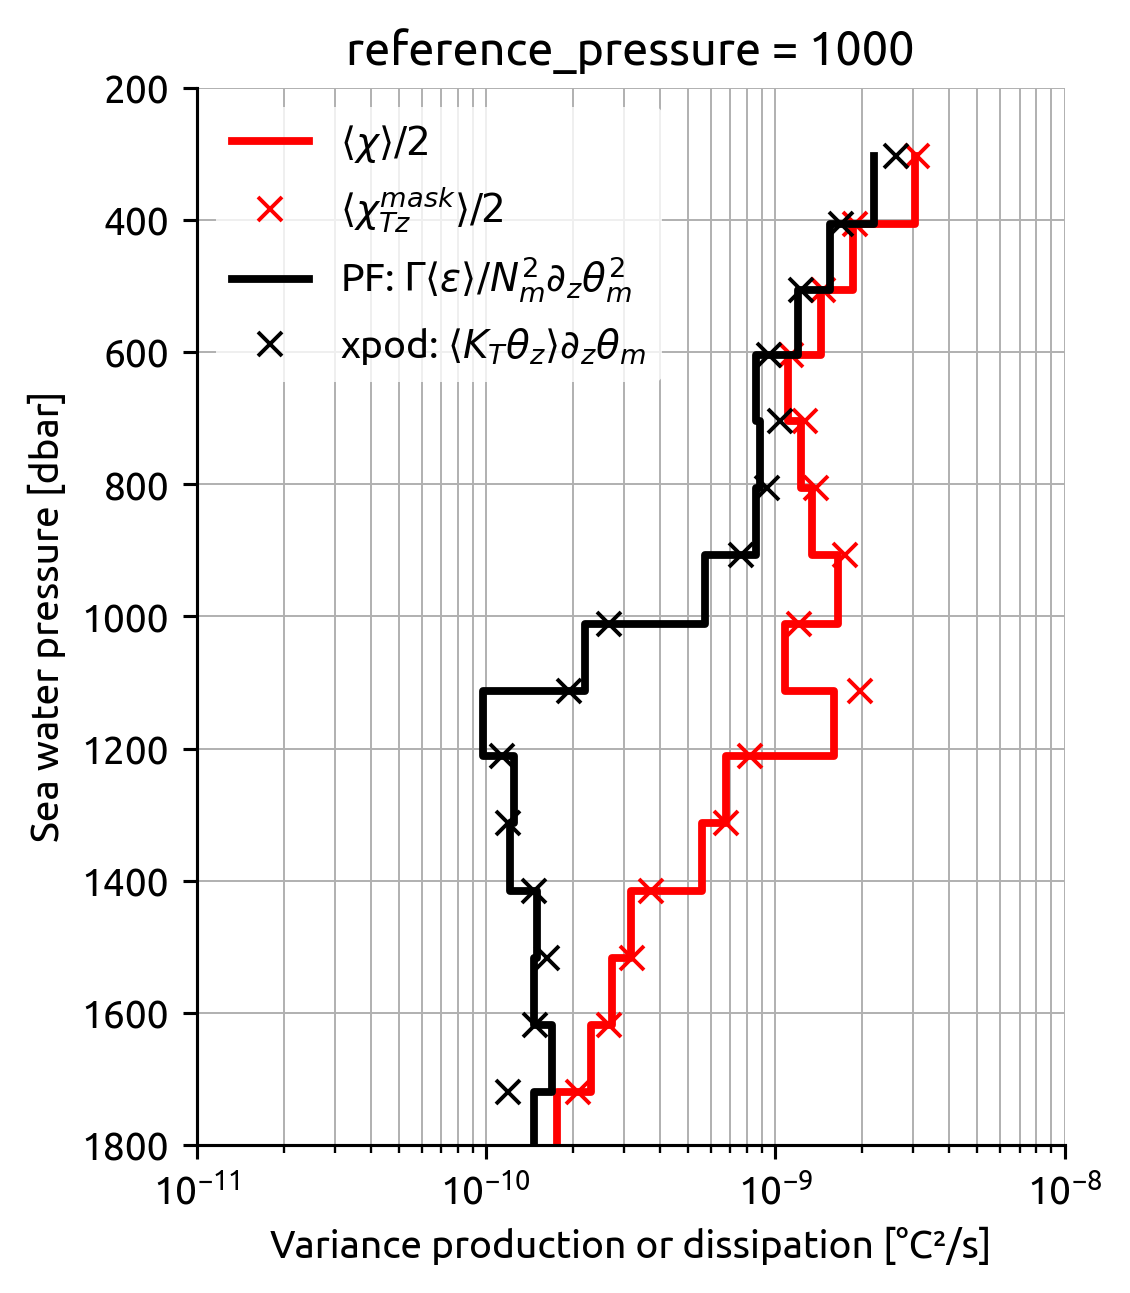

In [124]:
(chidens.chi / 2).cf.plot.step(
    y="pres",
    xscale="log",
    xlim=(1e-11, 1e-8),
    ylim=(1800, 200),
    color="r",
    lw=2,
    label="$⟨χ⟩/2$",
)
(chidens.chi_masked / 2).cf.plot.step(
    y="pres",
    xscale="log",
    xlim=(1e-11, 1e-8),
    ylim=(1800, 200),
    color="r",
    lw=2,
    label="$⟨χ^{mask}_{Tz}⟩/2$",
    ls="none",
    marker="x",
)
(chidens.Krho_m * chidens.dTdz_m ** 2).cf.plot.step(
    color="k", lw=2, label="PF: $Γ ⟨ε⟩/N_m^2  ∂_zθ_m^2$"
)
plt.grid(True, which="both", lw=0.5)

(chidens.KtTz * chidens.dTdz_m).cf.plot.step(
    color="k", marker="x", ls="none", label="χpod: $⟨K_T θ_z⟩ ∂_zθ_m$"
)
# (chidens.chi / 2 - chidens.Krho * chidens.dTdz ** 2).cf.plot.step(
#    y="pres",
#    xscale="log",
#    xlim=(1e-11, 1e-8),
#    ylim=(1800, 200),
#    color="darkblue",
#    lw=1,
#    label="$⟨χ⟩/2 - K_ρ θ^m_z$",
# )
plt.legend()
plt.xlabel("Variance production or dissipation [°C²/s]")
plt.gcf().set_size_inches((4, 5))

## Sensitivity to mean K estimate

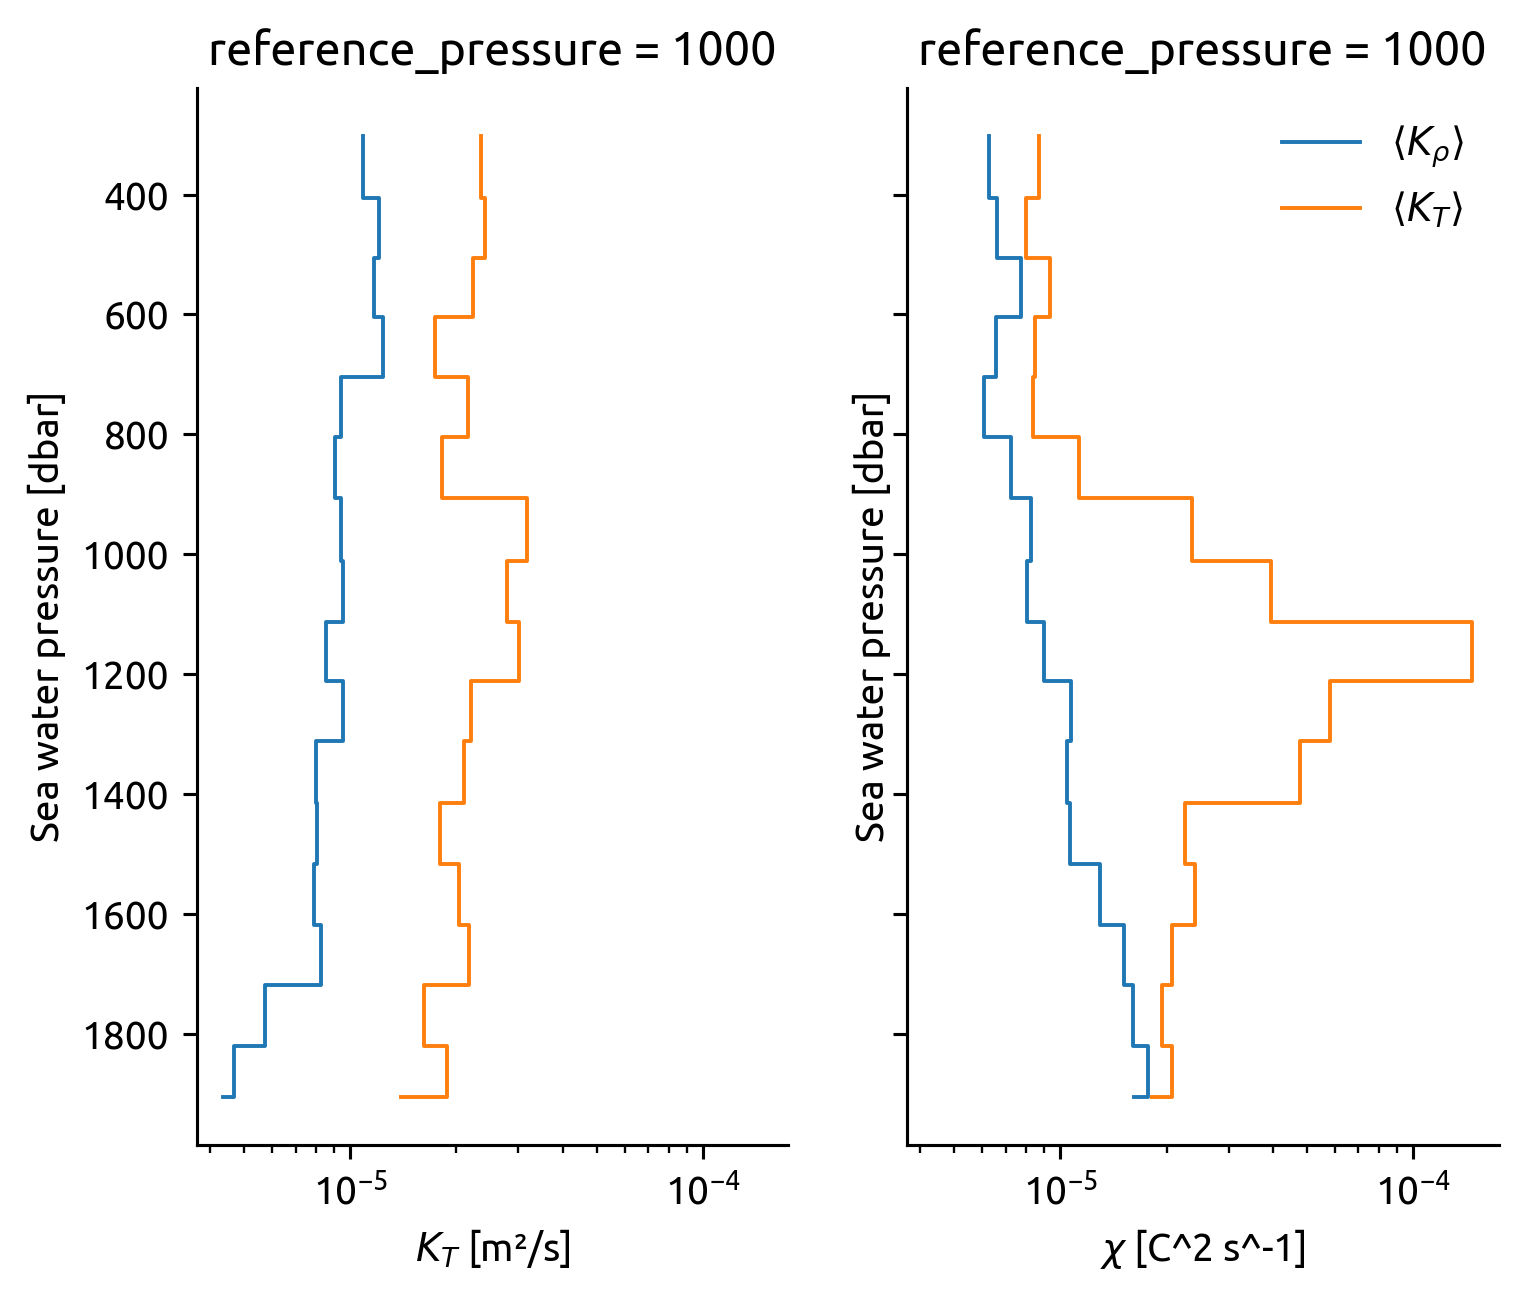

In [107]:
f, ax = plt.subplots(1, 2, sharey=True, sharex=True)
chidens.Krho.cf.plot.step(xscale="log", ax=ax[0])
chidens.Kt.cf.plot.step(ax=ax[0])
chidens.Krho_m.cf.plot.step(ax=ax[1])
chidens.Kt_m.cf.plot.step(ax=ax[1])
plt.legend(["$⟨K_ρ⟩$", "$⟨K_T⟩$", "$K_ρ^m = Γ ⟨ε⟩/N_m²$" "$K_T^m = ⟨χ⟩/2θ_m^2$"])
plt.gcf().set_size_inches((6, 5))

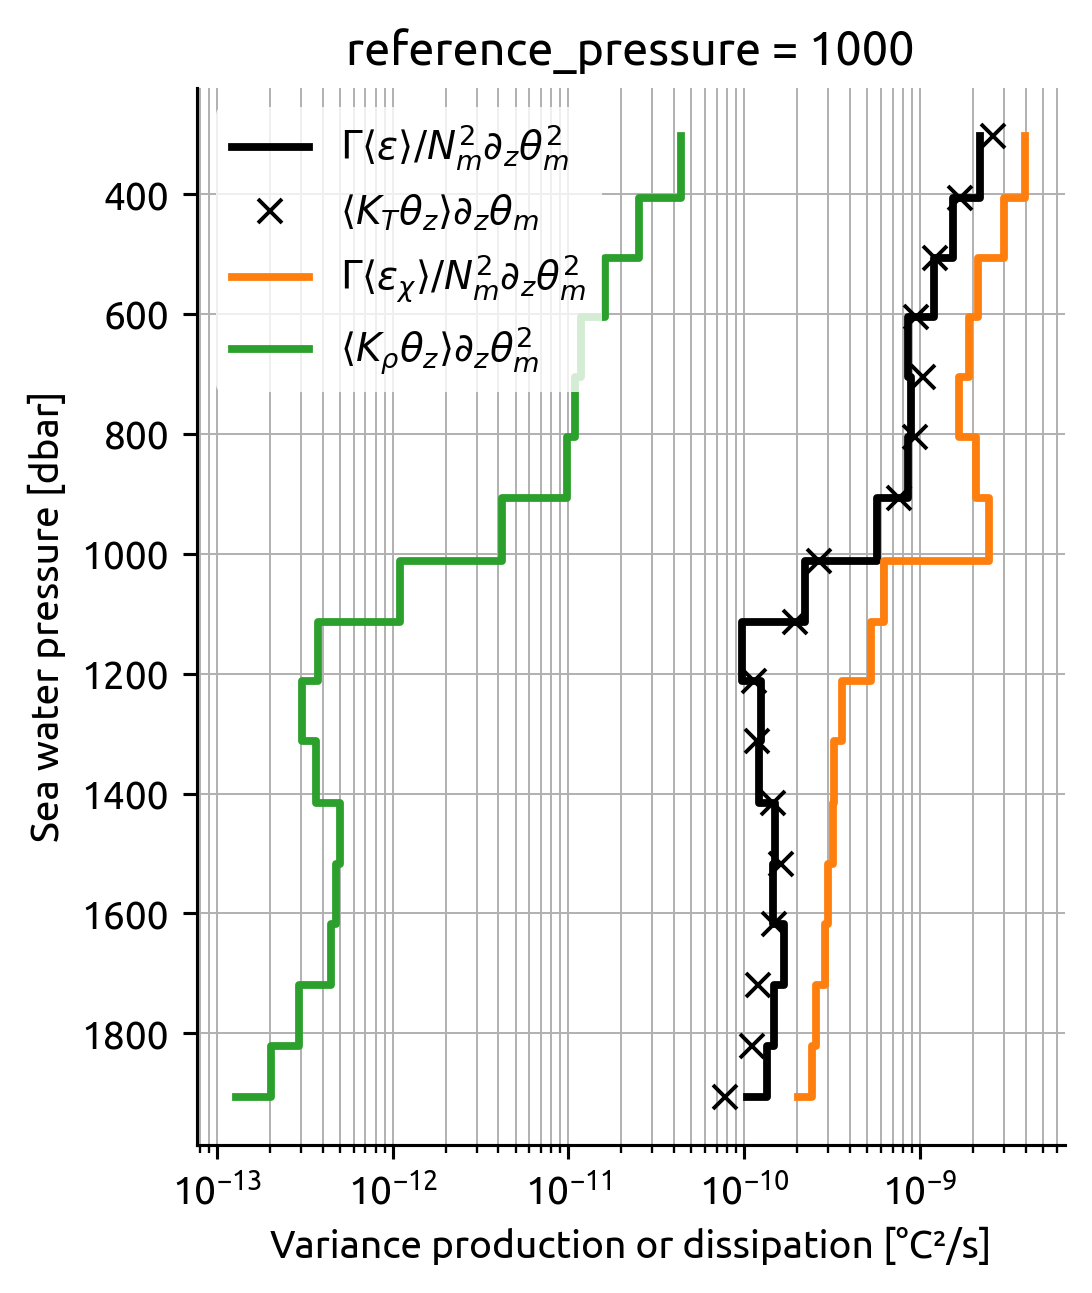

In [125]:
(chidens.Krho_m * chidens.dTdz_m ** 2).cf.plot.step(color="k", lw=2, label="$Γ ⟨ε⟩/N_m^2  ∂_zθ_m^2$")

(chidens.KtTz * chidens.dTdz_m).cf.plot.step(
    color="k", marker="x", ls="none", label="$⟨K_T θ_z⟩ ∂_zθ_m$"
)

(0.2 * chidens.eps_chi / chidens.N2_m * chidens.dTdz_m ** 2).cf.plot.step(color="C1", lw=2, label="$Γ ⟨ε_χ⟩/N_m^2  ∂_zθ_m^2$")

(chidens.KrhoTz * chidens.dTdz_m ** 2).cf.plot.step(lw=2, label="$⟨K_ρ θ_z⟩  ∂_zθ_m^2$", color="C2")

plt.grid(True, which="both", lw=0.5)

#(chidens.chi / 2 - chidens.Krho * chidens.dTdz ** 2).cf.plot.step(
#    y="pres",
#    xscale="log",
#    xlim=(1e-11, 1e-8),
#    ylim=(1800, 200),
#    color="darkblue",
#    lw=1,
#    label="$⟨χ⟩/2 - K_ρ θ^m_z$",
#)
plt.legend()
plt.xscale("log")
# plt.xlim(0, None)
plt.xlabel("Variance production or dissipation [°C²/s]")
plt.gcf().set_size_inches((4, 5))


### Todo:

See sensitivity to using
1. [x] $⟨K_ρ θ_z⟩ θ_z^m = ⟨Γε/N² θ_z⟩ θ_z^m$
2. [x] Use $Γ ⟨ε_χ⟩/N_m^2$
3. [x] Using neutral density bins instead of $σ_{1}$
4. [x] $T_z$ filtering

### Generate nice bins

In [11]:
(
    chidens.pden.dropna("pden_bins")
    .swap_dims({"pden_bins": "pres"})
    .interp(pres=np.arange(100, 2000, 100))
)

<xarray.DataArray 'pden' (pres: 19)>
array([          nan,           nan, 1031.05910221, 1031.25786643,
       1031.4289276 , 1031.57897311, 1031.72026509, 1031.85239499,
       1031.9653696 , 1032.0580463 , 1032.13639245, 1032.20298783,
       1032.25857209, 1032.30490323, 1032.34267842, 1032.37242716,
       1032.3957552 ,           nan,           nan])
Coordinates:
    reference_pressure  int64 1000
  * pres                (pres) int64 100 200 300 400 500 ... 1600 1700 1800 1900
Attributes:
    long_name:      Sea water temperature
    standard_name:  sea_water_potential_density
    units:          kg/m3